To run this demo you need to install theano and lasagne. As of right now the BatchNormLayer does not exist in the standard pip package so the development version is needed.

    pip install theano
    pip install lasagne
    pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

To convert this notebook into a python script run `jupyter nbconvert --to python lasagne-mnist-small-example.ipynb`

By Joseph Paul Cohen 2017


In [1]:
import theano, theano.tensor as T
import numpy as np, matplotlib.pyplot as plt
import os, time, random, sys
notebook_start_time = time.time()

import lasagne
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import Conv2DLayer, InputLayer, ConcatLayer, DenseLayer, Pool2DLayer, FlattenLayer

print "theano",theano.version.full_version
print "lasagne",lasagne.__version__

Using cuDNN version 5105 on context None
Mapped name None to device cuda0: GeForce GTX TITAN Black (0000:04:00.0)


theano 0.9.0rc2.dev-674f8d5148cb8dcea446e7243e629d8f83647da5
lasagne 0.2.dev1


In [2]:
#Set seed for random numbers:
np.random.seed(1234)
lasagne.random.set_rng(np.random.RandomState(1234))

In [3]:
if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

import gzip
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 1, 28, 28).transpose(0,1,3,2)
    data = np.asarray([np.rot90(np.fliplr(x[0])) for x in data])
    data = data.reshape(-1, 1, 28, 28)
    return data / np.float32(255)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

x_train = load_mnist_images('train-images-idx3-ubyte.gz')
t_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
x_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
t_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')
x_train, x_val = x_train[:-10000], x_train[-10000:]
t_train, t_val = t_train[:-10000], t_train[-10000:]

In [4]:
print "x_train", x_train.shape
print "t_train", t_train.shape
print "x_test", x_test.shape
print "t_test", t_test.shape

x_train (50000, 1, 28, 28)
t_train (50000,)
x_test (10000, 1, 28, 28)
t_test (10000,)


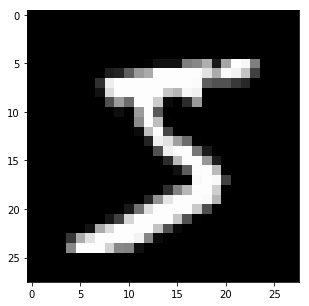

In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.imshow(x_train[0][0],interpolation='none', cmap='gray');

In [6]:
input_var = T.tensor4('inputs')

input_shape = (None, 1, 28, 28)
net = InputLayer(shape=input_shape, input_var=input_var)


net = BatchNormLayer(Conv2DLayer(net, num_filters=20,
        filter_size=5,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform(gain='relu')))
print net.output_shape


net = BatchNormLayer(Conv2DLayer(net, num_filters=20,
        filter_size=10,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform(gain='relu')))
print net.output_shape


net = FlattenLayer(net)  
net = DenseLayer(net, num_units=10, nonlinearity=lasagne.nonlinearities.softmax)
print net.output_shape

(None, 20, 24, 24)
(None, 20, 15, 15)
(None, 10)


In [7]:
output_shape = lasagne.layers.get_output_shape(net)
print "input_shape:",input_shape,"-> output_shape:",output_shape
sys.stdout.flush()

input_shape: (None, 1, 28, 28) -> output_shape: (None, 10)


In [8]:
#Output functions
output = lasagne.layers.get_output(net)
y = T.argmax(output, axis=1)
f_predict = theano.function([input_var], y)
print "DONE building output functions"

DONE building output functions


In [9]:
#Training function
target_var = T.ivector('target')
target_one_hot = T.extra_ops.to_one_hot(target_var, 10)
loss = lasagne.objectives.categorical_crossentropy(output, target_one_hot)
loss = loss.mean()

#create lr variable so we can adjust the learning rate without compiling
lr = theano.shared(np.array(0.001, dtype=theano.config.floatX))

params = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=lr)
#updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=lr, momentum=0.9)

f_train = theano.function([input_var, target_var], loss, updates=updates)
print "DONE building training functions"

DONE building training functions


In [10]:
#test to seee it the train function works
f_train(x_train[:10],t_train[:10])

array(4.338081359863281, dtype=float32)

In [11]:
#Test out a prediction
print "predicted", f_predict(x_train[:10])
print "true val ",t_train[:10]

predicted [5 0 4 1 9 2 1 3 1 4]
true val  [5 0 4 1 9 2 1 3 1 4]


In [12]:
# train model
batch_size = 2**9
print "batch_size:",batch_size

stats = []
for i in range(0,20):
    start_time = time.time()
    trainerror = []

    #Shuffle batches!
    order = range(0,len(x_train))
    random.shuffle(order)
    x_train = x_train[order]
    t_train = t_train[order]
    
    #Start batch training!
    for start in range(0, len(x_train), batch_size):
        x_batch = x_train[start:start + batch_size]
        t_batch = t_train[start:start + batch_size]
        cost = f_train(x_batch, t_batch)
        trainerror.append(cost)
        #print "batch error: %.5f" % cost
    elapsed_time = time.time() - start_time
    
    ## Calculate test error (just for logging)
    pred = np.array([])
    for start in range(0, len(x_test), batch_size):
        pred = np.append(pred,f_predict(x_test[start:start + batch_size]))
    testacc = np.mean(pred == t_test)
    
    epocherror = np.mean(trainerror)
    stats.append((testacc,epocherror))
    
    print "iteration: %d, trainerror: %.5f, accuracy: %.5f, seconds: %d" % (i, epocherror,testacc, elapsed_time)


batch_size: 512
iteration: 0, trainerror: 0.29832, accuracy: 0.96780, seconds: 6
iteration: 1, trainerror: 0.07765, accuracy: 0.98170, seconds: 6
iteration: 2, trainerror: 0.04962, accuracy: 0.98540, seconds: 6
iteration: 3, trainerror: 0.03509, accuracy: 0.98650, seconds: 7
iteration: 4, trainerror: 0.02737, accuracy: 0.98610, seconds: 7
iteration: 5, trainerror: 0.02031, accuracy: 0.98720, seconds: 7
iteration: 6, trainerror: 0.01481, accuracy: 0.98940, seconds: 7
iteration: 7, trainerror: 0.01085, accuracy: 0.98870, seconds: 7
iteration: 8, trainerror: 0.00788, accuracy: 0.99010, seconds: 7
iteration: 9, trainerror: 0.00521, accuracy: 0.99100, seconds: 7
iteration: 10, trainerror: 0.00392, accuracy: 0.98980, seconds: 7
iteration: 11, trainerror: 0.00284, accuracy: 0.99060, seconds: 7
iteration: 12, trainerror: 0.00213, accuracy: 0.99080, seconds: 7
iteration: 13, trainerror: 0.00158, accuracy: 0.99130, seconds: 7
iteration: 14, trainerror: 0.00138, accuracy: 0.99090, seconds: 7
iter

In [13]:
#Test out a prediction
print "predicted", f_predict(x_train[:10])
print "true val ",t_train[:10]

predicted [5 8 6 7 4 9 4 4 6 9]
true val  [5 8 6 7 4 9 4 4 6 9]


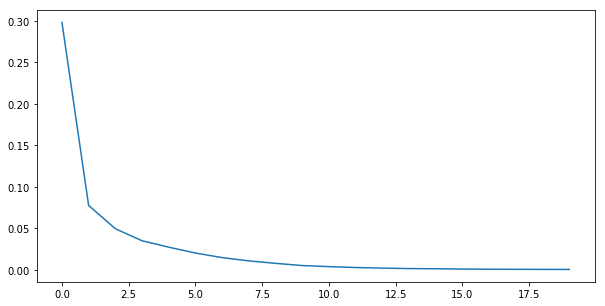

In [14]:
statsnp = np.rollaxis(np.asarray(stats),0,2)
plt.plot(statsnp[1])

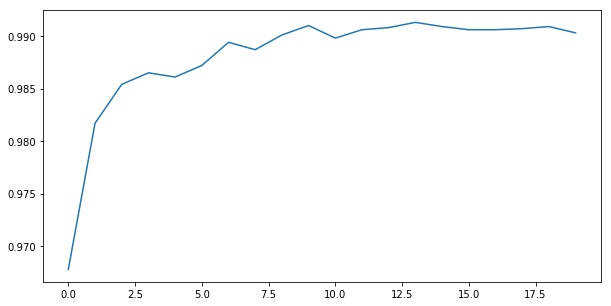

In [15]:
plt.plot(statsnp[0])

In [16]:
print "Max Testing Accuracy", max(statsnp[0])

Max Testing Accuracy 0.9913


In [17]:
notebook_elapsed_time = time.time() - notebook_start_time
print "Notebook took", notebook_elapsed_time/60.0, "minutes"

Notebook took 4.14655101697 minutes
